In [1]:
import pandas as pd
import random 
import json
import matplotlib.pyplot as plt

from functions import join_stocks_crypto, generate_rand_portfolios
from functions_post_clustering import simulate_evaluate_portfolio_subset, reoptimize_weights, kruskal_anova_test, dunn_bonferroni, run_simulation

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#GET THE DATA IN
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')

joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')
joined_df.index = pd.to_datetime(joined_df.index)

returns_all = joined_df.pct_change()


tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)


#Reassemble the portfolio jsons for minvar
min_var_portfolios = dict()
for i in range(1,1000):
    with open(f'min_variance_portfolio_jsons/my_dict{i}.json') as f:
        port = json.load(f)
        min_var_portfolios.update(port)

# with open(f"full_optimized_min_variance.json", "w") as f:
#     json.dump(min_var_portfolios, f, indent=4)

rand_ports_standard = random_portfolios.copy()
rand_ports_maxsharpe = reoptimize_weights(joined_df, random_portfolios, how='max_sharpe', min_weight=0.01)
rand_ports_equal_weights = reoptimize_weights(joined_df, random_portfolios, how='equal_weights', min_weight=0.01)

minvar_port_standard = min_var_portfolios.copy()
minvar_ports_maxsharpe = reoptimize_weights(joined_df, min_var_portfolios, how='max_sharpe', min_weight=0.01)
minvar_ports_equal_weights = reoptimize_weights(joined_df, min_var_portfolios, how='equal_weights', min_weight=0.01)


with open('all_optimized_sets_for_simulation.json') as f:
    crypto_supplemented_sets = json.load(f)


portfolio_sets = {#'rand_ports_standard': rand_ports_standard,
                  'rand_ports_maxsharpe': rand_ports_maxsharpe, 
                  'rand_ports_equalw': rand_ports_equal_weights,
                  #'minvar_port_standard': minvar_port_standard,  
                  'minvar_ports_maxsharpe': minvar_ports_maxsharpe, 
                  'minvar_ports_equalw': minvar_ports_equal_weights}

all_sets = portfolio_sets | crypto_supplemented_sets

equalw_sets = {k: v for k, v in all_sets.items() if 'equalw' in k}
maxsharpe_sets = {k: v for k, v in all_sets.items() if 'equalw' not in k}

In [3]:
# def estimate_t_df_for_portfolio(returns_df):
#     """
#     Estimate degrees of freedom for each asset, then take the average
#     """
#     from scipy import stats
#     import numpy as np
#     from scipy import optimize
    
#     asset_dfs = []
    
#     for column in returns_df.columns:
#         returns = returns_df[column].values
        
#         # Standardize the returns
#         standardized_returns = (returns - np.mean(returns)) / np.std(returns)
        
#         # Define negative log-likelihood function for t-distribution
#         def neg_ll(df):
#             return -np.sum(stats.t.logpdf(standardized_returns, df))
        
#         # Find optimal degrees of freedom
#         result = optimize.minimize_scalar(neg_ll, bounds=(1, 30), method='bounded')
        
#         asset_dfs.append(result.x)
    
#     # Return the average df (or minimum for more conservative estimate)
#     avg_df = np.mean(asset_dfs)
#     min_df = np.min(asset_dfs)
    
#     print(f"Average df: {avg_df:.2f}, Min df: {min_df:.2f}")
    
#     return avg_df  # or return min_df


# estimate_t_df_for_portfolio(returns_all)

SIMULATE AND EVALUATE

In [ ]:
import os

n_sims = 500
distribution_models = ['bootstrap']#, 'multivar_t', 'bootstrap']  # example list of 3 models
time_periods = [162, 189, 252]
portfolio_sets_group = {'equalw': equalw_sets, 'maxsharpe': maxsharpe_sets}

# Make sure output folders exist
os.makedirs('simulation_results', exist_ok=True)
#os.makedirs('dunn_results', exist_ok=True)

for set_name, set in portfolio_sets_group.items():
    for distribution_model in distribution_models:
        for time_period in time_periods:
            subset_statistics_results_dfs = dict()
            normality_results_dfs = dict()
            results_all_df = pd.DataFrame()

            for key, portfolio_set in set.items():
                simulations_results_dict, subset_statistics_df, normality = simulate_evaluate_portfolio_subset(
                    portfolio_set,
                    returns_all,
                    n_sims=n_sims,
                    t=time_period,
                    distribution_model=distribution_model,
                    winsorize=True,
                    winsorize_limits=(0.01, 0.01)
                )

                # Initialize nested dicts
                subset_statistics_results_dfs.setdefault(time_period, {})
                normality_results_dfs.setdefault(time_period, {})

                subset_statistics_results_dfs[time_period][key] = subset_statistics_df
                normality_results_dfs[time_period][key] = normality

                # Mean series and concat
                mean_series = subset_statistics_df.mean()
                mean_df = pd.DataFrame(mean_series, columns=[(time_period, key)])
                mean_df.columns = pd.MultiIndex.from_tuples(mean_df.columns)
                results_all_df = pd.concat([results_all_df, mean_df], axis=1)

            # Save to CSV with clear naming
            csv_filename = f"simulation_results/stats_{set_name}_{distribution_model}_t{time_period}.csv"
            results_all_df.to_csv(csv_filename)

            # Run and save Dunn-Bonferroni tests
            all_dunn_results = dict()
            dunn_bonferroni_test_results = dunn_bonferroni(subset_statistics_results_dfs[time_period], metrics='all')
            all_dunn_results[time_period] = dunn_bonferroni_test_results

            # Save to Excel
            excel_filename = f"simulation_results/dunn_matrix_{set_name}_{distribution_model}_t{time_period}.xlsx"
            with pd.ExcelWriter(excel_filename) as writer:
                for sheet_name, df in all_dunn_results[time_period].items():
                    df.to_excel(writer, sheet_name=sheet_name[:31])


            print(f'Done everything for {set_name}_{distribution_model}_t{time_period}, moving on')

In [9]:
csv_folder = 'simulation_results/'
output_excel = 'combined_stats.xlsx'

# Create Excel writer
with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
    for filename in os.listdir(csv_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(csv_folder, filename)
            sheet_name = os.path.splitext(filename)[0][:31]  # Max 31 characters for Excel sheet names

            # Read and write CSV to sheet
            df = pd.read_csv(file_path)
            df.to_excel(writer, sheet_name=sheet_name, index=False)


In [ ]:
n_sims = 500
distribution_model = 'multivar_norm'

subset_statistics_results_dfs = dict()
normality_results_dfs = dict()
results_all_df = pd.DataFrame()

for key, portfolio_set in equalw_sets.items():
    for time_period in  [162, 189, 252]:
        simulations_results_dict, subset_statistics_df, normality = simulate_evaluate_portfolio_subset(
            portfolio_set, returns_all, n_sims=n_sims, t=time_period, distribution_model=distribution_model, winsorize=True, winsorize_limits=(0.01, 0.01)
        )

        # Initialize nested dicts
        subset_statistics_results_dfs.setdefault(time_period, {})
        normality_results_dfs.setdefault(time_period, {})

        # Store in nested dictionaries
        subset_statistics_results_dfs[time_period][key] = subset_statistics_df
        normality_results_dfs[time_period][key] = normality

        # Extract mean results
        mean_series = subset_statistics_df.mean()
        mean_df = pd.DataFrame(mean_series, columns=[(time_period, key)])

        # Build MultiIndex columns
        mean_df.columns = pd.MultiIndex.from_tuples(mean_df.columns)

        # Concatenate along columns (axis=1)
        results_all_df = pd.concat([results_all_df, mean_df], axis=1)

        results_all_df.to_csv('simulation_results/')

In [15]:
import numpy as np

mean_returns_for_set = []
for key in simulations_results_dict.keys():
    x = pd.DataFrame(simulations_results_dict[key]).values[-1, :]
    initial_value = 100  # Your initial portfolio value
    holding_period_years = 162 / 252  # Convert days to year
    

    
    return_for_period = (x - initial_value) / initial_value
#     #annualised_return = (final_portfolio_values / initial_value) ** (1 / holding_period_years) - 1
#     annualised_return = (1 + return_for_period) ** (1/holding_period_years) - 1
#     mean_annualized_return = np.mean(annualised_return)
#     #print(np.mean(return_for_period))
#     avg_return_for_period = np.mean(return_for_period)#sum(return_for_period)/len(return_for_period)S
#     mean_returns_for_set.append(avg_return_for_period)


# sum(mean_returns_for_set) / len(mean_returns_for_set)

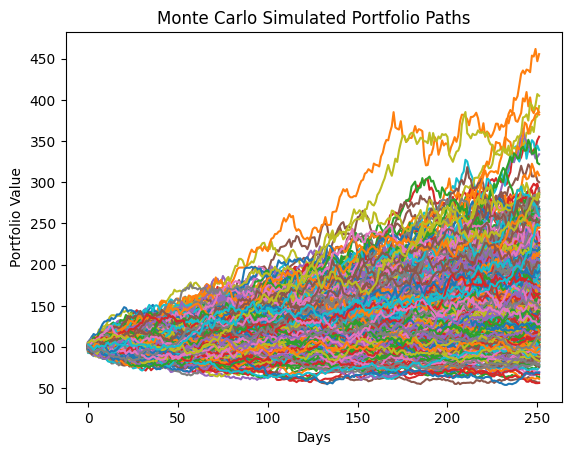

In [17]:
plt.plot(simulations_results_dict[key])
plt.title("Monte Carlo Simulated Portfolio Paths")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()

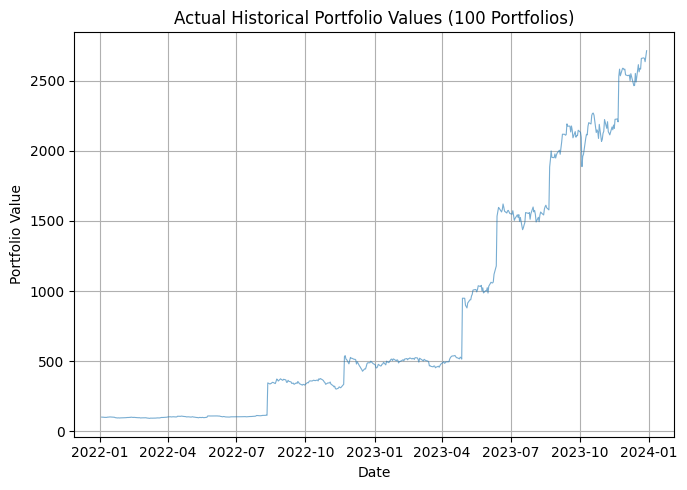

In [99]:
# portfolio = equalw_sets['minvar_w_cryptos_random_equalw']['portfolio_998']

# # Ensure weights sum to 1
# weights = pd.Series(portfolio)
# weights = weights / weights.sum()

# # Example: Load your historical prices into price_df (date index, tickers as columns)
# # price_df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

# # Normalize prices: start all at 100
# normalized_prices = joined_df[weights.index] / joined_df[weights.index].iloc[0] * 100

# # Multiply by weights to get portfolio value
# portfolio_value = normalized_prices.dot(weights)

# # Plot it
# plt.plot(portfolio_value)
# plt.title("Actual Historical Portfolio Value")
# plt.xlabel("Date")
# plt.ylabel("Portfolio Value")
# plt.grid(True)
# plt.show()



portfolios = equalw_sets['minvar_w_cryptos_random_equalw']

# Prepare the plot
plt.figure(figsize=(7, 5))

# Loop through each portfolio
for key, portfolio in portfolios.items():
    # if key == 'portfolio_25':
    #     continue
    # if key == 'portfolio_27':
    #     break
    if key == 'portfolio_26':
        pass
    else:
        continue
    
    weights = pd.Series(portfolio)
    weights = weights / weights.sum()  # Normalize weights

    # Align prices with portfolio tickers
    portfolio_prices = joined_df[weights.index]

    # Normalize prices
    normalized_prices = portfolio_prices / portfolio_prices.iloc[0] * 100

    # Compute portfolio value
    portfolio_value = normalized_prices.dot(weights)

    # Plot the result
    plt.plot(portfolio_value, alpha=0.6, linewidth=0.8)  # adjust alpha for better visibility

# Final plot settings
plt.title("Actual Historical Portfolio Values (100 Portfolios)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
extreme_port = equalw_sets['minvar_w_cryptos_random_equalw']['portfolio_26'].copy()
stock = 'INJUSDT'
extreme_stock = {}
extreme_stock[stock] = extreme_port[stock]
extreme_port

{'KT': 0.05555555555555555,
 'TEO': 0.05555555555555555,
 'TLK': 0.05555555555555555,
 'SAF.PA': 0.05555555555555555,
 'PJXC.F': 0.05555555555555555,
 'ULVR.L': 0.05555555555555555,
 'AD.AS': 0.05555555555555555,
 'KPN.AS': 0.05555555555555555,
 '601398.SS': 0.05555555555555555,
 '601939.SS': 0.05555555555555555,
 '2914.T': 0.05555555555555555,
 '9432.T': 0.05555555555555555,
 '9434.T': 0.05555555555555555,
 '0386.HK': 0.05555555555555555,
 '6288.HK': 0.05555555555555555,
 'INJUSDT': 0.05555555555555555,
 'NEARUSDT': 0.05555555555555555,
 'UNIUSDT': 0.05555555555555555}

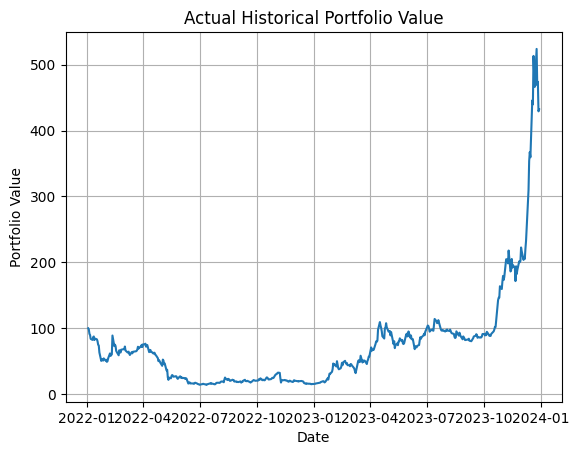

In [85]:
portfolio = extreme_stock.copy()
# Ensure weights sum to 1
weights = pd.Series(portfolio)
weights = weights / weights.sum()

# Example: Load your historical prices into price_df (date index, tickers as columns)
# price_df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

# Normalize prices: start all at 100
normalized_prices = joined_df[weights.index] / joined_df[weights.index].iloc[0] * 100

# Multiply by weights to get portfolio value
portfolio_value = normalized_prices.dot(weights)

# Plot it
plt.plot(portfolio_value)
plt.title("Actual Historical Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

In [87]:
returns_all['INJUSDT'].sort_values()

Date
2022-06-13   -0.318737
2022-05-11   -0.308570
2022-11-09   -0.265091
2022-11-08   -0.258486
2022-05-09   -0.230292
                ...   
2023-12-11    0.245017
2023-10-23    0.303214
2023-03-13    0.364236
2022-02-11    0.473895
2022-01-03         NaN
Name: INJUSDT, Length: 520, dtype: float64

In [90]:
for ticker in returns_all.columns:
    print(ticker, returns_all[ticker].max())

AAPL 0.08897465702030805
ADBE 0.10399176095832985
AMD 0.14269030896247625
AMZN 0.13535901735711864
ASML 0.14573196488774887
AVGO 0.11516192947770909
COST 0.07259137773666158
CRESY 0.2034739449292875
CSCO 0.05807957735322433
ERIC 0.0733943885657895
GOOGL 0.0765568809146897
LIN 0.07858058352304842
META 0.2328239452131604
MSFT 0.08226800479843832
NFLX 0.16054763621220602
PEP 0.04182297300058191
TMUS 0.10220845689813562
TSLA 0.11000180416824756
BCH 0.0824483160931
BSAC 0.0730136077191903
CIB 0.11190889502011259
EC 0.10385366592196799
HDB 0.07549265748671519
HMC 0.07202884322606518
IBN 0.06547612065332098
KEP 0.08639999389648434
KT 0.05648531780497956
LPL 0.10765557525899494
PKX 0.16251186477153534
SHG 0.05966006411344704
SKM 0.055139880249453155
SONY 0.09693193780551024
TAK 0.04689862882267759
TEO 0.22284644629527905
TGS 0.2456978666779721
TLK 0.044755187176708455
TM 0.06924692479568462
TSM 0.12004881558064096
ADMA 0.27530366756303737
APPF 0.15208801933181793
AXSM 0.5139002520569893
CRSP 0

162                      \
                  rand_ports_equalw minvar_ports_equalw   
annualised_return          0.240113            0.250563   
sharpe_annualized          1.039186            1.658655   

                                                  \
                  random_w_cryptos_kmeans_equalw   
annualised_return                       0.320482   
sharpe_annualized                       1.260567   

                                                                              \
                  random_w_cryptos_kshape_equalw random_w_cryptos_ahc_equalw   
annualised_return                       0.315059                    0.315670   
sharpe_annualized                       1.269948                    1.244412   

                                                  \
                  random_w_cryptos_random_equalw   
annualised_return                       0.196279   
sharpe_annualized                       0.725968   

                                                  \
                  minvar_w_cryptos_kmeans_equalw   
annualised_return                       0.330879   
sharpe_annualized                       1.546294   

                                                                              \
                  minvar_w_cryptos_kshape_equalw minvar_w_cryptos_ahc_equalw   
annualised_return                       0.329423                    0.326570   
sharpe_annualized                       1.544382                    1.539102   

                                                  
                  minvar_w_cryptos_random_equalw  
annualised_return                       0.204296  
sharpe_annualized                       0.940563

In [7]:
for time_period in  [126]:#, 189, 252]:
    print(f'\nFor Time Period of {time_period}:')
    print(kruskal_anova_test(subset_statistics_results_dfs[time_period], metrics='all', test='kruskal'))


For Time Period of 126:


KeyError: 126

In [ ]:
all_dunn_results = dict()
for time_period in [126]:#, 189, 252]:
    dunn_bonferroni_test_results = dunn_bonferroni(subset_statistics_results_dfs[time_period], metrics='all')
    all_dunn_results[time_period] = dunn_bonferroni_test_results

In [ ]:
all_dunn_results[126]['annualised_return']

,minvar_ports_equalw,minvar_w_cryptos_ahc_equalw,minvar_w_cryptos_kmeans_equalw,minvar_w_cryptos_kshape_equalw,minvar_w_cryptos_random_equalw,rand_ports_equalw,random_w_cryptos_ahc_equalw,random_w_cryptos_kmeans_equalw,random_w_cryptos_kshape_equalw,random_w_cryptos_random_equalw
minvar_ports_equalw,1.0000,0.0000,0.0000,0.0000,0.0063,1.0000,0.0000,0.0,0.0000,0.0001
minvar_w_cryptos_ahc_equalw,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0,0.2532,0.0000
minvar_w_cryptos_kmeans_equalw,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.4461,1.0,0.0965,0.0000
minvar_w_cryptos_kshape_equalw,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.3712,1.0,0.0781,0.0000
minvar_w_cryptos_random_equalw,0.0063,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0,0.0000,1.0000
rand_ports_equalw,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0,0.0000,0.0916
random_w_cryptos_ahc_equalw,0.0000,1.0000,0.4461,0.3712,0.0000,0.0000,1.0000,1.0,1.0000,0.0000
random_w_cryptos_kmeans_equalw,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0,1.0000,0.0000
random_w_cryptos_kshape_equalw,0.0000,0.2532,0.0965,0.0781,0.0000,0.0000,1.0000,1.0,1.0000,0.0000
random_w_cryptos_random_equalw,0.0001,0.0000,0.0000,0.0000,1.0000,0.0916,0.0000,0.0,0.0000,1.0000


In [ ]:
def analyze_portfolio_performance(summary_stats, dunn_results=None, alpha=0.05):
    """
    Analyze which portfolio strategies consistently outperform others
    
    Parameters:
    -----------
    summary_stats : DataFrame
        DataFrame with metrics as rows and MultiIndex columns (time_horizon, strategy)
    dunn_results : dict, optional
        Dictionary of Dunn-Bonferroni p-values by time horizon and metric
    alpha : float
        Significance threshold for statistical tests
        
    Returns:
    --------
    dict
        Dictionary containing structured performance insights
    """
    # Extract relevant information
    metrics = list(summary_stats.index)
    
    # Extract time horizons and strategies from MultiIndex
    time_horizons = sorted(summary_stats.columns.get_level_values(0).unique())
    strategies = sorted(summary_stats.columns.get_level_values(1).unique())
    
    # Initialize results
    results = {
        'ranking': {},
        'consistency': {},
        'statistical_significance': {},
        'best_overall': {}
    }
    
    # For each metric, rank strategies across all time horizons
    for metric in metrics:
        results['ranking'][metric] = {}
        metric_ranks = []
        
        for t in time_horizons:
            # Get values for this metric and time horizon across all strategies
            metric_values = {}
            
            for strategy in strategies:
                try:
                    value = summary_stats.loc[metric, (t, strategy)]
                    metric_values[strategy] = value
                except KeyError:
                    continue
            
            # Rank strategies (higher is better for returns and Sharpe, lower for volatility and VaR)
            if metric in ['annualised_return', 'sharpe_annualized']:
                ranking = sorted(metric_values.items(), key=lambda x: x[1], reverse=True)
            else:
                ranking = sorted(metric_values.items(), key=lambda x: x[1])
            
            # Store ranking for this time horizon
            results['ranking'][metric][t] = ranking
            
            # Store ranks for consistency check
            for rank, (strategy, _) in enumerate(ranking):
                metric_ranks.append({
                    'metric': metric,
                    'time_horizon': t,
                    'strategy': strategy,
                    'rank': rank + 1
                })
        
        # Create DataFrame of all ranks
        rank_df = pd.DataFrame(metric_ranks)
        
        # Calculate rank consistency (std of ranks across time horizons)
        if not rank_df.empty:
            rank_consistency = rank_df.groupby('strategy')['rank'].agg(['mean', 'std']).sort_values('mean')
            results['consistency'][metric] = rank_consistency.to_dict('index')
        
        # Determine best overall strategy for this metric
        best_strategies = []
        for t in time_horizons:
            if t in results['ranking'][metric] and results['ranking'][metric][t]:
                best_strategies.append(results['ranking'][metric][t][0][0])
        
        # Count occurrences of each strategy being best
        best_counts = {}
        for strategy in best_strategies:
            best_counts[strategy] = best_counts.get(strategy, 0) + 1
        
        # Find the most frequent best strategy
        most_consistent = max(best_counts.items(), key=lambda x: x[1]) if best_counts else (None, 0)
        results['best_overall'][metric] = {
            'strategy': most_consistent[0],
            'times_best': most_consistent[1],
            'total_horizons': len(time_horizons)
        }
    
    # If Dunn-Bonferroni results are provided, analyze statistical significance
    if dunn_results:
        for t in time_horizons:
            if t in dunn_results:
                for metric in metrics:
                    if metric in dunn_results[t]:
                        dunn_matrix = dunn_results[t][metric]
                        
                        # Count significant differences for each strategy
                        sig_diff_counts = {}
                        
                        for strategy in strategies:
                            sig_diffs = 0
                            sig_wins = 0
                            
                            for other_strategy in strategies:
                                if strategy != other_strategy:
                                    try:
                                        p_value = dunn_matrix.loc[strategy, other_strategy]
                                        
                                        if p_value < alpha:
                                            sig_diffs += 1
                                            
                                            # Check if difference is favorable
                                            strategy_value = summary_stats.loc[metric, (t, strategy)]
                                            other_value = summary_stats.loc[metric, (t, other_strategy)]
                                            
                                            # For return and Sharpe, higher is better
                                            if metric in ['annualised_return', 'sharpe_annualized']:
                                                if strategy_value > other_value:
                                                    sig_wins += 1
                                            # For volatility and VaR, lower is better
                                            else:
                                                if strategy_value < other_value:
                                                    sig_wins += 1
                                    except (KeyError, ValueError):
                                        pass
                            
                            sig_diff_counts[strategy] = {'total': sig_diffs, 'favorable': sig_wins}
                        
                        results['statistical_significance'].setdefault(metric, {})[t] = sig_diff_counts
    
    return results



res = analyze_portfolio_performance(results_all_df, all_dunn_results)

In [ ]:
def generate_performance_insights(results):
    """
    Generate clear insights from the portfolio analysis results
    
    Parameters:
    -----------
    results : dict
        Results from analyze_portfolio_performance
        
    Returns:
    --------
    str
        Formatted performance insights
    """
    insights = []
    
    # Add introduction
    insights.append("# Portfolio Strategy Performance Analysis")
    insights.append("\n## Consistent Top Performers\n")
    
    # Highlight consistently top-performing strategies
    for metric in results['best_overall']:
        best = results['best_overall'][metric]
        if best['strategy'] and best['times_best'] >= 2:  # Strategy was best in at least 2 time horizons
            metric_name = metric.replace('_', ' ').title()
            insights.append(f"- **{metric_name}**: {best['strategy']} was top-ranked in {best['times_best']}/{best['total_horizons']} time horizons")
    
    insights.append("\n## Ranking Consistency\n")
    
    # Show strategies with most consistent rankings
    for metric in results['consistency']:
        insights.append(f"### {metric.replace('_', ' ').title()}")
        
        # Find most consistent strategies (lowest std of ranks)
        consistency_data = [(strategy, data['mean'], data['std']) 
                           for strategy, data in results['consistency'][metric].items()]
        consistency_data.sort(key=lambda x: x[2])  # Sort by standard deviation
        
        for strategy, mean_rank, std_rank in consistency_data[:2]:  # Show top 2 most consistent
            if std_rank < 1.0:  # Only show if reasonably consistent
                insights.append(f"- {strategy}: Very consistent performance (avg rank: {mean_rank:.1f}, std: {std_rank:.2f})")
        
        insights.append("")
    
    # Add statistical significance insights if available
    if 'statistical_significance' in results and results['statistical_significance']:
        insights.append("\n## Statistically Significant Outperformance\n")
        
        for metric in results['statistical_significance']:
            significant_findings = []
            
            for t in sorted(results['statistical_significance'][metric].keys()):
                sig_counts = results['statistical_significance'][metric][t]
                
                # Find strategy with most significant favorable differences
                best_strategy = None
                max_favorable = 0
                
                for strategy, counts in sig_counts.items():
                    if counts['favorable'] > max_favorable:
                        max_favorable = counts['favorable'] 
                        best_strategy = strategy
                
                if best_strategy and max_favorable > 0:  # At least one significant difference
                    significant_findings.append(
                        f"- At {t} days: {best_strategy} significantly outperforms {max_favorable} other strategies"
                    )
            
            if significant_findings:
                insights.append(f"### {metric.replace('_', ' ').title()}")
                insights.extend(significant_findings)
                insights.append("")
    
    # Overall recommendation
    insights.append("\n## Overall Recommendation\n")
    
    # Count top performances across all metrics
    top_performers = {}
    for metric in results['best_overall']:
        strategy = results['best_overall'][metric]['strategy']
        if strategy:
            top_performers[strategy] = top_performers.get(strategy, 0) + results['best_overall'][metric]['times_best']
    
    if top_performers:
        best_overall = max(top_performers.items(), key=lambda x: x[1])
        insights.append(f"- **{best_overall[0]}** demonstrates the most consistent superior performance across metrics and time horizons")
        
        # Add specific strengths
        strengths = []
        for metric in results['best_overall']:
            if results['best_overall'][metric]['strategy'] == best_overall[0]:
                strengths.append(metric.replace('_', ' '))
        
        if strengths:
            insights.append(f"- Key strengths: {', '.join(strengths)}")
    
    print("\n".join(insights))
    #return "\n".join(insights)


generate_performance_insights(res)

# Portfolio Strategy Performance Analysis

## Consistent Top Performers


## Ranking Consistency

### Annualised Return

### Sharpe Annualized


## Statistically Significant Outperformance

### Annualised Return
- At 126 days: minvar_ports_equalw significantly outperforms 6 other strategies

### Sharpe Annualized
- At 126 days: minvar_ports_equalw significantly outperforms 6 other strategies


## Overall Recommendation

- **rand_ports_equalw** demonstrates the most consistent superior performance across metrics and time horizons
- Key strengths: annualised return
